In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

DATA_DIR = "/content/drive/MyDrive/data"

SELECTED_ACTIVITIES = ["sit", "walk", "run", "stairs"]
SELECTED_POSITIONS = [
    "dom_hand", "nondom_hand",
    "dom_pocket", "nondom_pocket",
    "backpack"
]

TRAIN_POSITIONS = ["dom_hand"]
TEST_POSITIONS  = ["nondom_hand"]

SAMPLING_RATE = 100
TRIM_SECONDS = 2

WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_g", "ay_g", "az_g", "gx_g", "gy_g", "gz_g"]

BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [14]:
def load_selected_csvs(base_dir):
    dfs = []
    for activity in SELECTED_ACTIVITIES:
        for position in SELECTED_POSITIONS:
            path = os.path.join(base_dir, activity, position, "*.csv")
            for csv_path in glob.glob(path):
                df = pd.read_csv(csv_path)
                df["activity"] = activity
                df["phone_position"] = position
                df["recording_id"] = os.path.splitext(
                    os.path.basename(csv_path)
                )[0]
                dfs.append(df)

    print(
        f"Loaded {len(dfs)} recordings | "
        f"Activities={SELECTED_ACTIVITIES} | "
        f"Positions={SELECTED_POSITIONS}"
    )
    return dfs

In [15]:
def trim_df(df):
    trim = SAMPLING_RATE * TRIM_SECONDS
    if len(df) <= 2 * trim:
        return None
    return df.iloc[trim:-trim].reset_index(drop=True)

def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]

def build_dataset_lstm(dfs, feature_cols):
    X, y, groups, positions = [], [], [], []

    for df in dfs:
        df = trim_df(df)
        if df is None:
            continue

        for w in sliding_windows(df):
            X.append(w[feature_cols].values)
            y.append(w["activity"].iloc[0])
            groups.append(w["recording_id"].iloc[0])
            positions.append(w["phone_position"].iloc[0])

    return (
        np.array(X),
        np.array(y),
        np.array(groups),
        np.array(positions)
    )

In [16]:
class ActivityDataset(Dataset):
    def __init__(self, X, y, scaler=None):
        if scaler is not None:
            orig_shape = X.shape
            X = scaler.transform(X.reshape(-1, X.shape[-1])).reshape(orig_shape)
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
class LSTM(nn.Module):
    def __init__(self, num_features, num_classes, hidden_size=128, num_layers=2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0,
            bidirectional=True
        )

        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(self.relu(self.fc1(x)))
        return self.fc2(x)

In [18]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def evaluate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, preds, labels = 0, [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            out = model(Xb)
            loss = criterion(out, yb)
            total_loss += loss.item()
            preds.extend(out.argmax(1).cpu().numpy())
            labels.extend(yb.cpu().numpy())

    acc = np.mean(np.array(preds) == np.array(labels))
    return total_loss / len(loader), acc, preds, labels

In [23]:
def evaluate_lstm_cross_position(
    X, y, groups, positions,
    train_positions, test_positions,
    title, num_features
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nUsing device: {device}")

    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    num_classes = len(le.classes_)

    train_mask = np.isin(positions, train_positions)
    test_mask  = np.isin(positions, test_positions)

    X_train, y_train, g_train = X[train_mask], y_enc[train_mask], groups[train_mask]
    X_test,  y_test           = X[test_mask],  y_enc[test_mask]

    print(f"Train samples: {len(X_train)} | Test samples: {len(X_test)}")

    cv = GroupKFold(n_splits=5)
    y_true_all, y_pred_all = [], []

    for fold, (tr_idx, val_idx) in enumerate(cv.split(X_train, y_train, g_train), 1):
        print(f"Fold {fold}/5")

        X_tr, X_val = X_train[tr_idx], X_train[val_idx]
        y_tr, y_val = y_train[tr_idx], y_train[val_idx]

        scaler = StandardScaler()
        scaler.fit(X_tr.reshape(-1, X_tr.shape[-1]))

        train_loader = DataLoader(
            ActivityDataset(X_tr, y_tr, scaler),
            batch_size=BATCH_SIZE, shuffle=True
        )
        val_loader = DataLoader(
            ActivityDataset(X_val, y_val, scaler),
            batch_size=BATCH_SIZE, shuffle=False
        )
        test_loader = DataLoader(
            ActivityDataset(X_test, y_test, scaler),
            batch_size=BATCH_SIZE, shuffle=False
        )

        model = LSTM(num_features, num_classes).to(device)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        criterion = nn.CrossEntropyLoss()

        scheduler = lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=15, min_lr=1e-5
        )

        for epoch in range(EPOCHS):
            train_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc, _, _ = evaluate_epoch(
                model, val_loader, criterion, device
            )
            scheduler.step(val_loss)

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{EPOCHS} | Val Acc: {val_acc:.4f}")

        _, _, preds, labels = evaluate_epoch(
            model, test_loader, criterion, device
        )
        y_true_all.extend(labels)
        y_pred_all.extend(preds)

    y_true_lbl = le.inverse_transform(y_true_all)
    y_pred_lbl = le.inverse_transform(y_pred_all)

    print(f"\n=== {title} ===\n")
    print(classification_report(y_true_lbl, y_pred_lbl, digits=4))

    cm = confusion_matrix(y_true_lbl, y_pred_lbl, labels=SELECTED_ACTIVITIES)
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=SELECTED_ACTIVITIES,
        yticklabels=SELECTED_ACTIVITIES,
        cmap="Blues"
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return {
        "precision": precision_score(y_true_lbl, y_pred_lbl, average="macro"),
        "recall": recall_score(y_true_lbl, y_pred_lbl, average="macro"),
        "f1": f1_score(y_true_lbl, y_pred_lbl, average="macro")
    }

Loaded 100 recordings | Activities=['sit', 'walk', 'run', 'stairs'] | Positions=['dom_hand', 'nondom_hand', 'dom_pocket', 'nondom_pocket', 'backpack']

Using device: cuda
Train samples: 1005 | Test samples: 1005
Fold 1/5
Epoch 10/100 | Val Acc: 0.9900
Epoch 20/100 | Val Acc: 0.9552
Epoch 30/100 | Val Acc: 0.9502
Epoch 40/100 | Val Acc: 0.9055
Epoch 50/100 | Val Acc: 0.9403
Epoch 60/100 | Val Acc: 0.9353
Epoch 70/100 | Val Acc: 0.9403
Epoch 80/100 | Val Acc: 0.9403
Epoch 90/100 | Val Acc: 0.9403
Epoch 100/100 | Val Acc: 0.9403
Fold 2/5
Epoch 10/100 | Val Acc: 0.7761
Epoch 20/100 | Val Acc: 0.9254
Epoch 30/100 | Val Acc: 0.9602
Epoch 40/100 | Val Acc: 0.9453
Epoch 50/100 | Val Acc: 0.9801
Epoch 60/100 | Val Acc: 0.9751
Epoch 70/100 | Val Acc: 0.9751
Epoch 80/100 | Val Acc: 0.9751
Epoch 90/100 | Val Acc: 0.9751
Epoch 100/100 | Val Acc: 0.9751
Fold 3/5
Epoch 10/100 | Val Acc: 0.9950
Epoch 20/100 | Val Acc: 1.0000
Epoch 30/100 | Val Acc: 0.9851
Epoch 40/100 | Val Acc: 0.9851
Epoch 50/100 | 

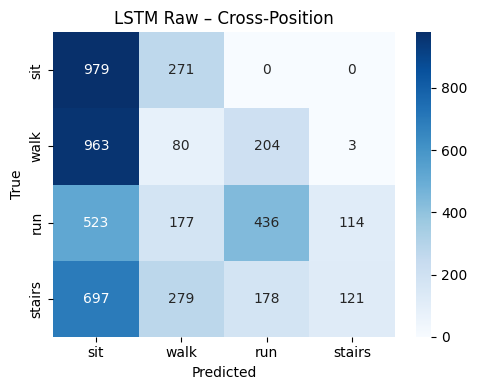


Using device: cuda
Train samples: 1005 | Test samples: 1005
Fold 1/5
Epoch 10/100 | Val Acc: 0.8557
Epoch 20/100 | Val Acc: 0.5572
Epoch 30/100 | Val Acc: 0.9303
Epoch 40/100 | Val Acc: 0.9652
Epoch 50/100 | Val Acc: 0.8358
Epoch 60/100 | Val Acc: 0.9801
Epoch 70/100 | Val Acc: 0.9602
Epoch 80/100 | Val Acc: 0.9602
Epoch 90/100 | Val Acc: 0.9751
Epoch 100/100 | Val Acc: 0.9801
Fold 2/5
Epoch 10/100 | Val Acc: 0.9353
Epoch 20/100 | Val Acc: 0.9403
Epoch 30/100 | Val Acc: 0.9204
Epoch 40/100 | Val Acc: 0.9204
Epoch 50/100 | Val Acc: 0.9204
Epoch 60/100 | Val Acc: 0.9254
Epoch 70/100 | Val Acc: 0.9254
Epoch 80/100 | Val Acc: 0.9204
Epoch 90/100 | Val Acc: 0.9204
Epoch 100/100 | Val Acc: 0.9254
Fold 3/5
Epoch 10/100 | Val Acc: 0.8756
Epoch 20/100 | Val Acc: 0.8109
Epoch 30/100 | Val Acc: 0.9552
Epoch 40/100 | Val Acc: 0.9602
Epoch 50/100 | Val Acc: 0.9453
Epoch 60/100 | Val Acc: 0.9851
Epoch 70/100 | Val Acc: 0.9453
Epoch 80/100 | Val Acc: 1.0000
Epoch 90/100 | Val Acc: 0.9900
Epoch 100/1

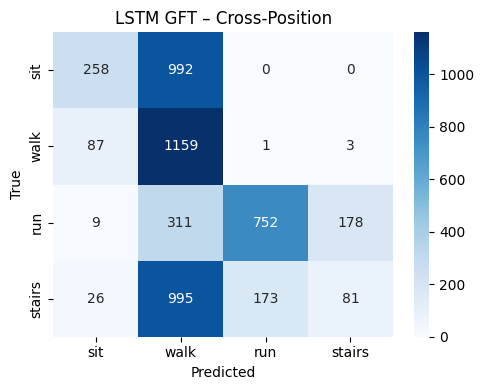


Summary
Raw: {'precision': 0.3625393635986792, 'recall': 0.3227254901960785, 'f1': 0.2757958529490257}
GFT: {'precision': 0.5338661234597872, 'recall': 0.4496823529411765, 'f1': 0.4013997647762445}


In [24]:
if __name__ == "__main__":
    recordings = load_selected_csvs(DATA_DIR)
    X_raw, y_raw, g_raw, p_raw = build_dataset_lstm(recordings, RAW_FEATURES)
    raw_metrics = evaluate_lstm_cross_position(
        X_raw, y_raw, g_raw, p_raw,
        TRAIN_POSITIONS, TEST_POSITIONS,
        "LSTM Raw – Cross-Position",
        num_features=len(RAW_FEATURES)
    )

    X_gft, y_gft, g_gft, p_gft = build_dataset_lstm(recordings, GFT_FEATURES)
    gft_metrics = evaluate_lstm_cross_position(
        X_gft, y_gft, g_gft, p_gft,
        TRAIN_POSITIONS, TEST_POSITIONS,
        "LSTM GFT – Cross-Position",
        num_features=len(GFT_FEATURES)
    )

    print("\nSummary")
    print("Raw:", raw_metrics)
    print("GFT:", gft_metrics)